In [1]:
# 가우스 잡음 추가 함수
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

# 가우스 노이즈
# noisy_pixel = original_pixel + N(u=0, e=scale)  u = 평균, e = 스케일
# 평균 = 0 : 픽셀을 전체적으로 밝히거나 어둡게 하지 않음
# 표준편차 = scale -> 값이 클수록 노이즈가 강해짐
# 0.8 -> 노이즈의 양 많고, 숫자 일부를 흐릿

In [2]:
def gaussian_noise(x, scale=0.8):
    gaussian_data_x = x + np.random.normal(
        loc = 0, scale = scale, size = x.shape
    )
    gaussian_data_x = np.clip(gaussian_data_x, 0, 1) # 이미지픽셀의 값을 0과 1사이로 정규화
    gaussian_data_x = torch.tensor(gaussian_data_x, dtype=torch.float32)
    return gaussian_data_x


In [3]:
training_data = MNIST(root='./', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='./', train=False, download=True, transform=ToTensor())

C:\Users\playdata2\AppData\Local\Temp\ipykernel_16808\1267212853.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_x = x + np.random.normal(
C:\Users\playdata2\AppData\Local\Temp\ipykernel_16808\1267212853.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x, dtype=torch.float32)


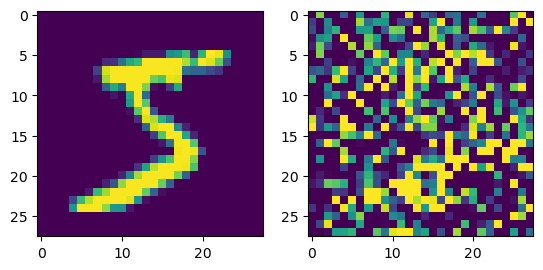

In [4]:
img, label = next(iter(training_data))
gaussian = gaussian_noise(img)
img = img.permute(1,2,0)
gaussian = gaussian.permute(1,2,0)

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(gaussian)

In [5]:
# 학습용 데이터셋
from torch.utils.data.dataset import Dataset
class Denoise(Dataset):
    def __init__(self):
        self.mnist = MNIST(root='./', train=True, download=True, transform=ToTensor())
        self.data = []
        # 잡음
        for data, label in self.mnist:
            noisy = gaussian_noise(data)
            self.data.append(noisy)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        data = self.data[index]
        label = self.mnist.data[index] / 255 # 원본이미지도 0 ~ 1 정규화
        return data, label

In [6]:
# 합성곱 기본 블럭
from torch import nn
# conv-relu-conv-relu
class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel, hidden_channel):
        super(BasicBlock, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channel, hidden_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, out_channel, kernel_size=3, padding=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.model(x)

In [7]:
sample_data = torch.randn(1, 28, 28)
sample_model = BasicBlock(1, 20, 10)
sample_model(sample_data).size()

torch.Size([20, 28, 28])

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = BasicBlock(1,16,16)
        self.conv2 = BasicBlock(16,8,8)
        self.pool = nn.AvgPool2d(2)
    def forward(self, x):
        x = self.pool(self.conv1(x)) # 1,16,14,14 
        out = self.pool(self.conv2(x)) # 1,8,7,7
        return out

In [9]:
sample_data = torch.randn(1,1,28,28)
temp_encoder = Encoder()
result_encoder = temp_encoder(sample_data)

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = BasicBlock(8,8,8)
        self.conv2 = BasicBlock(8,16,16)
        # 출력층
        self.conv3 = nn.Conv2d(16, 1, kernel_size=3, padding=1)

        # 업샘플링 층
        self.upsampling1 = nn.ConvTranspose2d(8,8, kernel_size=2, stride=2)
        self.upsampling2 = nn.ConvTranspose2d(16,16, kernel_size=2, stride=2)
    def forward(self, x):
        x = self.upsampling1(self.conv1(x))
        x = self.upsampling2(self.conv2(x))
        out = self.conv3(x)
        return out

In [11]:
d = Decoder()
d(result_encoder).size()

torch.Size([1, 1, 28, 28])

In [12]:
# CAE 오토인코더
# 인코더와 디코더를 연결 : 인코더의 출력을 디코더의 입력으로 제공
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

In [13]:
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = Denoise()
train_loader = DataLoader(train_dataset, batch_size=32)
model = CAE().to(device)
optim = Adam(model.parameters(), lr=1e-3)

C:\Users\playdata2\AppData\Local\Temp\ipykernel_16808\1267212853.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_x = x + np.random.normal(
C:\Users\playdata2\AppData\Local\Temp\ipykernel_16808\1267212853.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x, dtype=torch.float32)


In [14]:
data, label = next(iter(train_loader))
data.size()

torch.Size([32, 1, 28, 28])

In [ ]:
criterian = nn.MSELoss()
for epoch in range(2):
    loop = tqdm(train_loader)
    for data, label in loop:
        optim.zero_grad()
        data, label = data.to(device), label.to(device)
        pred = model(data)
        loss = criterian(pred, label)
        loss.backward()
        loop.set_postfix({'loss' : f'{loss.item():.4f}'})
torch.save(model.state_dict(), 'CAE.pth')

  0%|          | 0/1875 [00:00<?, ?it/s]c:\Users\playdata2\miniconda3\envs\deep\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 28, 28])) that is different to the input size (torch.Size([32, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 59%|█████▉    | 1102/1875 [01:08<00:26, 29.29it/s, loss=0.0819]

In [ ]:
model.load_state_dict(torch.load('CAE.pth', map_location=device))

C:\Users\playdata2\AppData\Local\Temp\ipykernel_4620\1445865355.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('CAE.pth', map_location=

<All keys matched successfully>

In [ ]:
sample = test_data.data[0]
sample_noise = gaussian_noise(sample).unsqueeze(0)
print(sample_noise.size())
predict = model(sample_noise)
predict = predict.permute(1,2,0)
predict = predict.detach().numpy()

torch.Size([1, 28, 28])


C:\Users\playdata2\AppData\Local\Temp\ipykernel_4620\1267212853.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_x = x + np.random.normal(
C:\Users\playdata2\AppData\Local\Temp\ipykernel_4620\1267212853.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x, dtype=torch.float32)


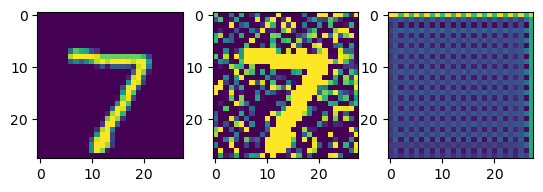

In [ ]:
plt.subplot(1,3,1)
plt.imshow(sample)
plt.subplot(1,3,2)
plt.imshow(sample_noise.squeeze(0))
plt.subplot(1,3,3)
plt.imshow(predict)